This Python Notebook allows a user to perform and alter my algorithms to understand the ability to use my statistic and make it their own. It also requires the Lahman2016 database. This notebook should be run in order and when mySQL scripts are given, they must be run with the use lahman2016 at the top of the script and appending each script following the last.

In [178]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import csv
import os

In [179]:
print("USED TO STORE DATA FROM THE mySQL")
direct = os.getcwd()
data = direct + '\data'
location = ''
i = 0
while(i < len(data)):
    #print(data[i])
    if data[i] == "\\":
        #print("here")
        location = location + data[i] + '\\'
        i += 1
    else:
        location = location + data[i]
        i += 1
print(location)

USED TO STORE DATA FROM THE mySQL
C:\\Users\\zacka\\Documents\\GitHub\\Sabermetrics-Project\\data


The first script defines the time period that will be analyzed. It consists of three inputs: starting year (syear), final year (fyear), and minimum years (myears). These are all integers provided by the user. In my example I use 2005 and 2017 as my interval to be assessed and define minimum years to be 5. This means players that played at least 5 years from 2005 to 2017 will be included in my data.

There is one required mySQL script that needs to be run prior to being able to select the data. This script takes all the players in the 'masters' table and grabs strictly the year of their debute and final games as long as the fields aren't blank.

IN ORDER TO SAVE: the data files to CSV files you have to remove the --secure-file-priv folder by setting the local variable in the my.conf file to "". To find the file location run "SHOW VARIABLES LIKE 'secure_file_priv';". 

IN ORDER TO SAVE: create a directory in the C:\ location called data. This is where the files will be stored.

Run the script below, with your inputs, to get the necessary mySQL query to grab this data:

In [180]:
syear = 2005
fyear = 2017
myears = 5
enclosed = '"'
terminate = "'\\r\\n'"
print("drop table if exists tot_years;")
print("create table tot_years as")
print("select years_in_league.playerID, convert(years_in_league.final,unsigned) - convert(years_in_league.deb, unsigned) as total_years")
print("from years_in_league")
print("where cast(years_in_league.deb as unsigned) >=", syear, "and convert(years_in_league.final,unsigned) - convert(years_in_league.deb, unsigned) >", myears, "and cast(years_in_league.final as unsigned) <=", fyear, ";")
print()
print("select * from tot_years")
print("INTO OUTFILE '%s\\\\tot_years.csv'" % location) 
print("FIELDS ENCLOSED BY '%s'" % enclosed) 
print("TERMINATED BY ';'") 
print("ESCAPED BY '%s'" % enclosed) 
print("LINES TERMINATED BY %s;" % terminate)
print()

drop table if exists tot_years;
create table tot_years as
select years_in_league.playerID, convert(years_in_league.final,unsigned) - convert(years_in_league.deb, unsigned) as total_years
from years_in_league
where cast(years_in_league.deb as unsigned) >= 2005 and convert(years_in_league.final,unsigned) - convert(years_in_league.deb, unsigned) > 5 and cast(years_in_league.final as unsigned) <= 2017 ;

select * from tot_years
INTO OUTFILE 'C:\\Users\\zacka\\Documents\\GitHub\\Sabermetrics-Project\\data\\tot_years.csv'
FIELDS ENCLOSED BY '"'
TERMINATED BY ';'
ESCAPED BY '"'
LINES TERMINATED BY '\r\n';



Run this mySQL query under the previous one with Lahman2016 to get the number of viable players in the time range you've specified. My result gave me a possible 525 players to analyze.

Next, we use these players to determine their statistics for the categories that I have chosen. Once we have grabbed all the data I will allow the user to choose the weights according to their opinion. I will provide my example weights after loading the data. First, define the required number of at bats (AB) to be considered a viable candidate during that year. 

In [181]:
AB_req = 200
years = np.floor(np.linspace(syear,fyear,fyear-syear+1))
enclosed = '"'
terminate = "'\\r\\n'"

for i in years:
    print("select tot_years.playerID, b.yearID, b.RBI, b.2B, b.3B, b.HR, b.CS, b.GIDP")
    print("from tot_years")
    print("join batting b on b.playerID = tot_years.playerID")
    print("where b.AB >=", AB_req, "and b.yearID =", int(i))
    print("order by tot_years.playerID")
    print("INTO OUTFILE '%s\\\\%i.csv'" % (location,int(i))) 
    print("FIELDS ENCLOSED BY '%s'" % enclosed) 
    print("TERMINATED BY ';'") 
    print("ESCAPED BY '%s'" % enclosed) 
    print("LINES TERMINATED BY %s;" % terminate)
    print()
    
    

select tot_years.playerID, b.yearID, b.RBI, b.2B, b.3B, b.HR, b.CS, b.GIDP
from tot_years
join batting b on b.playerID = tot_years.playerID
where b.AB >= 200 and b.yearID = 2005
order by tot_years.playerID
INTO OUTFILE 'C:\\Users\\zacka\\Documents\\GitHub\\Sabermetrics-Project\\data\\2005.csv'
FIELDS ENCLOSED BY '"'
TERMINATED BY ';'
ESCAPED BY '"'
LINES TERMINATED BY '\r\n';

select tot_years.playerID, b.yearID, b.RBI, b.2B, b.3B, b.HR, b.CS, b.GIDP
from tot_years
join batting b on b.playerID = tot_years.playerID
where b.AB >= 200 and b.yearID = 2006
order by tot_years.playerID
INTO OUTFILE 'C:\\Users\\zacka\\Documents\\GitHub\\Sabermetrics-Project\\data\\2006.csv'
FIELDS ENCLOSED BY '"'
TERMINATED BY ';'
ESCAPED BY '"'
LINES TERMINATED BY '\r\n';

select tot_years.playerID, b.yearID, b.RBI, b.2B, b.3B, b.HR, b.CS, b.GIDP
from tot_years
join batting b on b.playerID = tot_years.playerID
where b.AB >= 200 and b.yearID = 2007
order by tot_years.playerID
INTO OUTFILE 'C:\\Users\\zacka\\Do

Now, we will read in all the data we just found with the mySQL queries. Create a three dimensional array using the known information from the tot_years which is # of players x # of attributes and scoring factor x # years.

In [182]:
class Player:
    def __init__(self,pID,num_yrs):
        self.ID = pID
        self.num_years_played = num_yrs
        self.stats = np.zeros((fyear-syear+1,7))
        self.score = np.zeros(fyear-syear+1)

In [183]:
#print("First read in the tot_years csv")
ty = direct + '\data\\tot_years.xlsx'
#print(ty)

wb = load_workbook(ty)
sheet = wb.get_sheet_by_name('Sheet1')

df = pd.DataFrame(sheet.values)
data = sheet.values
cols = next(data)[0:]
pIDs_tot = [r[0] for r in data]
#print(pIDs_tot)

wb = load_workbook(ty)
sheet = wb.get_sheet_by_name('Sheet1')
df = pd.DataFrame(sheet.values)
data = sheet.values
cols = next(data)[0:]
yr_tot = [r[1] for r in data]
#print(yr_tot)

player_dict = {}
player_matrix = []
for i in range(0,len(pIDs_tot)):
    player_dict[pIDs_tot[i]] = i
    player_matrix.append(Player(pIDs_tot[i],yr_tot[i]))
    

In [184]:
print("START READING THE DATA IN FOR ALL THE YEARS")
years_array = ['\\2005.xlsx','\\2006.xlsx','\\2007.xlsx','\\2008.xlsx','\\2009.xlsx','\\2010.xlsx','\\2011.xlsx','\\2012.xlsx','\\2013.xlsx','\\2014.xlsx','\\2015.xlsx','\\2016.xlsx','\\2017.xlsx']

for i in range(0,len(years)):
    ty = direct + '\data' + years_array[i]
    #print(ty)

    wb = load_workbook(ty)
    sheet = wb.get_sheet_by_name('Sheet1')

    df = pd.DataFrame(sheet.values)
    data = sheet.values
    cols = next(data)[0:]
    player_reading = [r for r in data]
    #print(pIDs_tot)
    
    for j in range(0,len(player_reading)):
        if player_reading[j][0] != None:
            print(player_reading[j])
            local_ind = player_dict[player_reading[j][0]]
            player_matrix[local_ind].stats[i][0] = player_reading[j][2]
            player_matrix[local_ind].stats[i][1] = player_reading[j][3]
            player_matrix[local_ind].stats[i][2] = player_reading[j][4]
            player_matrix[local_ind].stats[i][3] = player_reading[j][5]
            player_matrix[local_ind].stats[i][4] = player_reading[j][6]
            player_matrix[local_ind].stats[i][5] = player_reading[j][7]
        else:
            print("STRANGE")
        #print(player_reading[j])
    

START READING THE DATA IN FOR ALL THE YEARS
('canoro01', 2005.0, 62.0, 34.0, 4.0, 14.0, 3.0, 16.0)
('doumiry01', 2005.0, 35.0, 13.0, 1.0, 6.0, 1.0, 5.0)
('encared01', 2005.0, 31.0, 16.0, 0.0, 9.0, 0.0, 8.0)
('francje02', 2005.0, 45.0, 20.0, 1.0, 14.0, 2.0, 4.0)
('hardyjj01', 2005.0, 50.0, 22.0, 1.0, 9.0, 0.0, 10.0)
('hillaa01', 2005.0, 40.0, 25.0, 3.0, 3.0, 1.0, 5.0)
('johnsda06', 2005.0, 58.0, 21.0, 0.0, 15.0, 1.0, 11.0)
('johnske05', 2005.0, 40.0, 12.0, 3.0, 9.0, 1.0, 11.0)
('morsemi01', 2005.0, 23.0, 10.0, 1.0, 3.0, 1.0, 9.0)
('repkoja01', 2005.0, 30.0, 15.0, 3.0, 8.0, 0.0, 7.0)
('teahema01', 2005.0, 55.0, 29.0, 4.0, 7.0, 2.0, 13.0)
('cabreme01', 2006.0, 50.0, 26.0, 2.0, 7.0, 5.0, 9.0)
('canoro01', 2006.0, 78.0, 41.0, 1.0, 15.0, 2.0, 19.0)
('cedenro02', 2006.0, 41.0, 18.0, 7.0, 6.0, 8.0, 10.0)
('drewst01', 2006.0, 23.0, 13.0, 7.0, 5.0, 0.0, 1.0)
('encared01', 2006.0, 72.0, 33.0, 1.0, 15.0, 3.0, 9.0)
('ethiean01', 2006.0, 55.0, 20.0, 7.0, 11.0, 5.0, 11.0)
('fieldpr01', 2006.0, 81.0, 

In [196]:
# THESE ARE THE WEIGHTS I USE TO CALCULATE THE BEST BATTER SCORE
wRBI = .4
w2B = .3
w3B = .3
wHR = .3
wCS = -.2
wGIDP = -.5

for i in range(0,len(player_matrix)):
    for j in range(0,len(years)):
        evaled = wRBI*player_matrix[i].stats[j][0] + w2B*player_matrix[i].stats[j][1] + w3B*player_matrix[i].stats[j][2] + wHR*player_matrix[i].stats[j][3] + wCS*player_matrix[i].stats[j][4] + wGIDP*player_matrix[i].stats[j][5]
        print(evaled)
        player_matrix[i].score[j] = evaled

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
45.8
50.0
25.4
41.3
29.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
14.9
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
13.4
23.6
28.2
23.2
14.3
28.9
30.8
44.6
0.0
0.0
0.0
0.0
0.0
0.0
0.0
14.3
9.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11.7
45.4
22.8
21.6
25.1
0.0
0.0
16.2
0.0
0.0
0.0
0.0
0.0
13.4
0.0
32.1
19.1
16.2
2.1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
22.0
28.4
14.6
31.2
24.9
26.4
32.7
20.6
7.8
12.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
14.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
40.1
44.0
37.7
32.9
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
31.2
6.3
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25.6
13.6
21.9
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
22.0
20.7
62.2
41.2
41.2
21.1
31.8
21.6
46.9
27.1
29.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


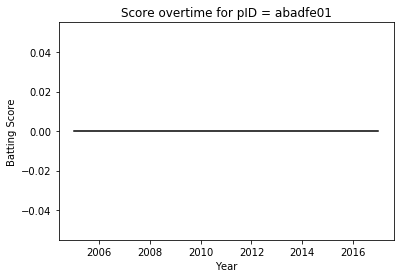

In [195]:
# PLOT SOME EXAMPLES FROM SOME OF THE PLAYERS
plt.plot(years,player_matrix[4].score[:],'k')
plt.xlabel('Year')
plt.ylabel('Batting Score')
plt.title('Score overtime for pID = %s' % player_matrix[0].ID)
plt.show()
